In [1]:
import cvxpy as cvx
import numpy as np
import time
import matplotlib.pyplot as plt

# Support Vector Machines
### Objetivo do notebook
O objetivo deste notebook é meramente mostrar como resolver alguns dos problemas de otimização mostrados no cap 8. do livro Learning From Data usando python. Para um tutorial de cvxpy, visite https://www.cvxpy.org/tutorial/index.html.

### Maior margem

O objetivo do SVM é encontrar o hiperplano $(b, w^*)$ de separação que maximiza a margem entre as classes. Para encontrar o hiperplano ótimo, é preciso resolver o problema de minimização (eq. 8.4 Mostafa):

\begin{equation*}
\begin{aligned}
& \underset{b, w}{\text{minimize}}
& & \frac{1}{2}w^{T}w \\
& \text{subject to}
& & y_n(w^Tx_n + b) \geq 1 \qquad(n = 1, \dots, N)
\end{aligned}
\end{equation*}

Nesse exemplo é usado o pacote pra python cvxpy para resolver o problema de otimização. 

##### Toy dataset
Abaixo é criado um "toy dataset" igual ao do exemplo 8.2 do livro.

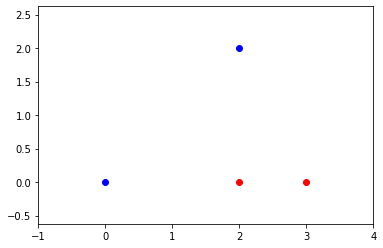

In [2]:
X = np.array([[0.0, 0.0], [2.0, 2.0], [2.0, 0.0], [3.0, 0.0]])
y = np.array([-1.0, -1.0, 1.0, 1.0])

N, d = X.shape

plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], color='blue')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='red')
plt.axis('equal')
plt.ylim(-1, 3)
plt.xlim(-1, 4)
plt.show()

Como $\frac{1}{2}w^Tw = \frac{1}{2}\vert\vert w \vert \vert^2$, usamos as funções do cvxpy (https://www.cvxpy.org/tutorial/functions/index.html) para escrever o problema de otimização:

In [3]:
# "Standard" svm
w = cvx.Variable(2)
b = cvx.Variable()

constraints = [cvx.multiply(y, X*w + b) >= 1]
obj = cvx.Minimize(0.5*(cvx.norm(w, 2)**2))
svm = cvx.Problem(obj, constraints)

svm.solve()

print("Linear classifier weights: ", w.value[0], w.value[1], b.value)

Linear classifier weights:  1.000000000087375 -1.0000000000815807 -1.0000000002375025


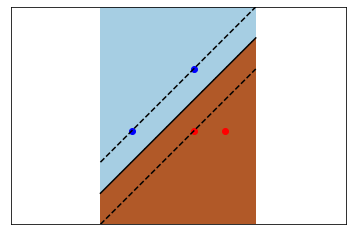

In [4]:
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

# Copiado de http://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
def PlotLinearClf(X, y, w, b):
    xlim = [np.min(X[:, 0]) - 1.0, np.max(X[:, 0]) + 1.0]
    
    xx = np.array(xlim)
    a = -w[0]/w[1]
    yy = a*xx - b/w[1]
    
    margin = 1.0/np.sqrt(np.sum(w**2))
    yy_down = yy - np.sqrt(1 + a**2)*margin
    yy_up = yy + np.sqrt(1 + a**2)*margin
    
    ymin = np.min([np.min(X[:, 1]), np.min(yy), np.min(yy_down), np.min(yy_up)])
    ymax = np.max([np.max(X[:, 1]), np.max(yy), np.max(yy_down), np.max(yy_up)])
    
    XX, YY = np.mgrid[xx[0]:xx[1]:200j, ymin:ymax:200j]
    Z = predict(np.c_[XX.ravel(), YY.ravel()], w, b)
    test = np.c_[XX.ravel(), YY.ravel()][:2]
    
    Z = Z.reshape(XX.shape)
    
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)
    
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')
    
    plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], color='blue')
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='red')
    
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ymin, ymax)
    plt.axis('tight')
    plt.xticks(())
    plt.yticks(())
    plt.axis('equal')
        
    plt.show()
    
PlotLinearClf(X, y, np.asarray(w.value).reshape(-1), b.value)

#### Formulação de programação quadrática
Na equação 8.6, é apresentado o problema de otimização quadrática na forma matricial:

\begin{equation*}
\begin{aligned}
& \underset{u}{\text{minimize}}
& & \frac{1}{2}u^{T}Qu + p^Tu \\
& \text{subject to}
& & Au \geq c
\end{aligned}
\end{equation*}

Nesta formulação, o trabalho consiste em criar os vetores $c$ e $p$ além das matrizes $A$ e $Q$. (Vejam o quadro "Linear Hard-Margin SVM with QP" na página 10 do cap. 8):

In [5]:
# Quadratic Programming formulation
c = np.ones(N)
p = np.zeros((d + 1))
Q = np.identity(d + 1)
Q[0, 0] = 0.0
A = np.zeros((N, d + 1))
A[:, 0] = y
A[:, 1:] = X*y[:, np.newaxis]

u = cvx.Variable(d + 1)

constraints = [A*u >= c]
obj = cvx.Minimize(0.5*cvx.quad_form(u, Q) + p.T*u)

svm_qp = cvx.Problem(obj, constraints)

start = time.time()
svm_qp.solve()
end = time.time()
print(end-start)

0.03598380088806152


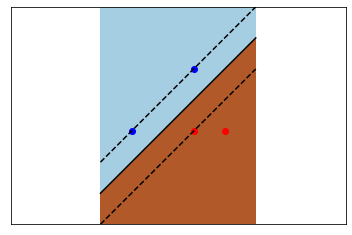

In [6]:
w = np.asarray(u.value).reshape(-1)

PlotLinearClf(X, y, w[1:], w[0])

#### SVM Dual
Na equação 8.6, é apresentado o problema de otimização quadrática na forma matricial:

\begin{equation*}
\begin{aligned}
& \underset{\alpha \geq 0}{\text{max}} \quad \underset{u}{\text{min}} \mathcal{L}(u, \alpha)
\end{aligned}
\end{equation*}

Onde $\mathcal{L}(u,\alpha)$ é:

\begin{equation*}
\mathcal{L}(u, \alpha) = \frac{1}{2}u^{T}Qu + p^Tu + \alpha(c - a^Tu)
\end{equation*}

O exercício 8.11, mostra que esse problema é equivalente ao problema de programação quadrática:

\begin{equation*}
\begin{aligned}
& \underset{\alpha}{\text{minimize}}
& & \frac{1}{2}\alpha^{T}Q_{D}\alpha + \textbf{1}^T_{N}\alpha \\
& \text{subject to}
& & A_{D}\alpha \geq \textbf{0}_{N + 2}
\end{aligned}
\end{equation*}

Onde $A_{D}$ e $Q_{D}$ são definidos no item (a) do exercício (e no quadro "Hard Margin SVM with Dual QP" da página 30).

In [7]:
# Dual problem formulation
# 1. Dual "manual"
alpha = cvx.Variable(N)

Q_d = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Q_d[i, j] = y[i]*y[j]*np.dot(X[i], X[j])

A_d = np.eye(N+2, N, -2)
A_d[0] = y
A_d[1] = -y

constraints_dual = [A_d*alpha >= np.zeros(N + 2)]
obj_dual = cvx.Minimize(0.5*cvx.quad_form(alpha, Q_d) - np.ones(N).T*alpha)
svm_dual = cvx.Problem(obj_dual, constraints_dual)

start = time.time()
svm_dual.solve()
end = time.time()
print(end-start)

print(alpha.value)

0.023100852966308594
[ 5.00001087e-01  4.99999939e-01  1.00000043e+00 -4.15275725e-07]


[ 0.99999974 -0.99999988]
b_dual:  -1.0


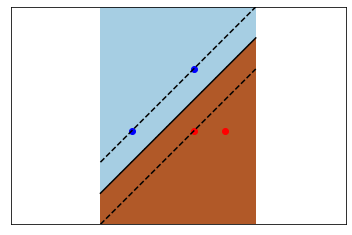

In [8]:
# Recuperar w a partir do dual:
alpha_arr = np.asarray(alpha.value).reshape(-1)
w_dual = np.sum((X*alpha_arr[:, np.newaxis])*y[:, np.newaxis], axis=0)
print(w_dual)

#
sv_idx = 0
for i in range(len(alpha_arr)):
    if alpha_arr[i] > 0:
        sv_idx = i
        break

b_dual = y[sv_idx] - np.dot(w_dual, X[sv_idx])
print("b_dual: ", b_dual)

PlotLinearClf(X, y, w_dual, b_dual)